# Vision Transformers

[Paper here](https://arxiv.org/pdf/2010.11929)


In [1]:
%cd "Deep-Learning-From-Scratch/Transformers/ViT/"

/teamspace/studios/this_studio/Deep-Learning-From-Scratch/Transformers/ViT


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [3]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR100
from torchvision.transforms import v2
from torchvision.utils import make_grid
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
wandb.require('core')
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: lakshyaag. Use `wandb login --relogin` to force relogin


True

In [60]:
# Hyperparameters
NUM_CLASSES = 100
PATCH_SIZE = 4
NUM_BLOCKS = 12
DIM_EMBEDDING = 512
DIM_HIDDEN = DIM_EMBEDDING * 4
NUM_HEADS = 8
DROPOUT_RATE = 0.1
IMAGE_SHAPE = (3, 32, 32)

BATCH_SIZE = 128
N_EPOCHS = 50
LEARNING_RATE = 3e-4

## Load the dataset


In [6]:
true_labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]


In [7]:
train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=v2.ToImage()
)
test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=v2.ToImage()
)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)



(
    (array([0.50707516, 0.48654887, 0.44091784]), array([0.26733429, 0.25643846, 0.27615047])),
    (array([0.50879641, 0.48739301, 0.44194221]), array([0.26825157, 0.25736374, 0.27709577]))
)

In [9]:
train_transform = v2.Compose(
    [
        v2.Resize((32)),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = v2.Compose(
    [
        v2.Resize((32)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_test, std_pixel_test),
    ]
)


In [10]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel, device=x.device).view(3, 1, 1) + torch.tensor(
        mean_pixel, device=x.device
    ).view(3, 1, 1)
    x = v2.ToPILImage()(x)

    return x

In [11]:
full_train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [30]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [31]:
len(train_loader), len(val_loader), len(test_loader)

(274, 118, 79)

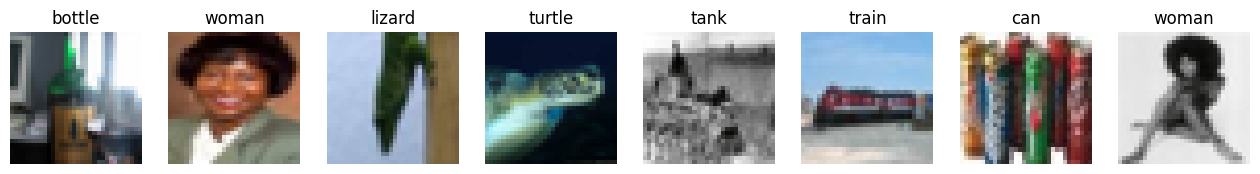

In [32]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img)
    axs[i].set_title(f"{true_labels[label]}")
    axs[i].axis("off")

plt.show()


## Build the architecture

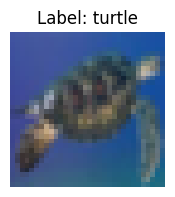

In [33]:
sample_image, sample_target = train_dataset[132]
plt.figure(figsize=(2, 5))
plt.imshow(reverse_transform(sample_image))
plt.title(f"Label: {true_labels[sample_target]}")
plt.axis("off")
plt.show()

In [34]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_embd, image_shape, dropout=0.0, debug=False):
        super(PatchEmbedding, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd

        self.n_channels, img_height, img_width = image_shape
        self.n_patches = (img_height // self.patch_size) * (
            img_width // self.patch_size
        )

        self.input_dim = self.n_channels * self.patch_size * self.patch_size

        self.projection = nn.Linear(self.input_dim, self.d_embd)

        # [CLASS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_embd))

        # Learnabled positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, self.d_embd)
        )

        self.dropout = nn.Dropout(dropout)

        self.pre_norm = nn.LayerNorm(self.input_dim)
        self.post_norm = nn.LayerNorm(self.d_embd)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[EMBEDDING] Input")
        b, c, h, w = x.shape

        assert (
            h % self.patch_size == 0 and w % self.patch_size == 0
        ), "Invalid patch size"
        assert c == self.n_channels, "Invalid number of channels"

        # (B, C, H, W) -> (B, C, H // patch_size, patch_size, W // patch_size, patch_size)
        x = x.reshape(
            b,
            c,
            h // self.patch_size,
            self.patch_size,
            w // self.patch_size,
            self.patch_size,
        )
        # (B, C, H // patch_size, patch_size, W // patch_size, patch_size) -> (B, H // patch_size, W // patch_size, C, patch_size, patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)
        # (B, H // patch_size, W // patch_size, C, patch_size, patch_size) -> (B, H // patch_size * W // patch_size, C * patch_size * patch_size)
        x = x.reshape(b, -1, self.input_dim)
        self._debug_print(x, "[EMBEDDING] Flattened")

        x = self.pre_norm(x)
        x = self.projection(x)
        self._debug_print(x, "[EMBEDDING] Projected")
        x = self.post_norm(x)

        cls_token = self.cls_token.repeat(b, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        self._debug_print(x, "[EMBEDDING] CLS token")

        x += self.pos_embedding
        self._debug_print(x, "[EMBEDDING] POS embedding")

        x = self.dropout(x)

        return x

In [35]:
PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape, debug=True)(
    sample_image.unsqueeze(0)
)


[EMBEDDING] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] Flattened: torch.Size([1, 64, 48])

[EMBEDDING] Projected: torch.Size([1, 64, 512])

[EMBEDDING] CLS token: torch.Size([1, 65, 512])

[EMBEDDING] POS embedding: torch.Size([1, 65, 512])


tensor([[[ 2.3895e+00, -1.7039e-03,  4.5514e-01,  ...,  1.2563e+00,
           7.6627e-01,  1.0003e+00],
         [ 3.3944e+00,  2.7521e-01, -1.0180e+00,  ...,  6.2562e-01,
          -4.8604e-01,  9.8834e-01],
         [ 2.8103e+00, -1.1363e+00,  8.3327e-01,  ...,  1.3357e+00,
          -1.2202e+00,  2.0262e+00],
         ...,
         [ 2.7159e+00, -5.8112e-01,  1.9203e+00,  ..., -5.6535e-01,
          -8.2692e-01,  1.9090e+00],
         [ 2.3828e+00, -1.8803e-01,  1.4697e+00,  ...,  1.2641e-01,
          -6.4171e-01,  3.5953e+00],
         [ 1.9188e+00,  2.6331e-01,  7.0185e-01,  ..., -1.2332e+00,
           5.6016e-01,  7.1219e-01]]], grad_fn=<AddBackward0>)

In [36]:
class EncoderMLP(nn.Module):
    def __init__(self, d_embd, d_hidden, dropout=0.0, debug=False):
        super(EncoderMLP, self).__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(d_embd),
            nn.Linear(d_embd, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_embd),
            nn.Dropout(dropout),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[MLP] Input")
        x = self.net(x)
        self._debug_print(x, "[MLP] Output")

        return x

In [37]:
EncoderMLP(d_embd=512, d_hidden=2048, debug=True)(torch.randn(1, 197, 512))

[MLP] Input: torch.Size([1, 197, 512])

[MLP] Output: torch.Size([1, 197, 512])


tensor([[[-0.1266,  0.2221,  0.0951,  ...,  0.0410,  0.2769,  0.5866],
         [-0.2539, -0.0706,  0.0396,  ...,  0.3304,  0.1530, -0.0667],
         [ 0.1603,  0.1448,  0.1902,  ...,  0.2364,  0.0123, -0.1744],
         ...,
         [-0.1177, -0.1811, -0.3964,  ...,  0.0753, -0.1148,  0.1452],
         [-0.0133, -0.0476, -0.3241,  ...,  0.0175,  0.0302, -0.0590],
         [-0.0064, -0.0871,  0.1893,  ..., -0.1652,  0.1155, -0.1650]]],
       grad_fn=<ViewBackward0>)

In [38]:
class EncoderAttention(nn.Module):
    def __init__(self, d_embd, n_heads, dropout=0.0, debug=False):
        super(EncoderAttention, self).__init__()

        self.d_embd = d_embd
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

        self.norm = nn.LayerNorm(d_embd)
        self.dropout = nn.Dropout(dropout)

        self.qkv = nn.Linear(d_embd, 3 * d_embd, bias=False)
        self.projection = nn.Sequential(nn.Linear(d_embd, d_embd), nn.Dropout(dropout))

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        b, n, _ = x.shape

        self._debug_print(x, "[ATTENTION] Input")
        x = self.norm(x)

        q, k, v = self.qkv(x).view(b, self.n_heads, n, -1).chunk(3, dim=-1)
        self._debug_print(q, "[ATTENTION] Q")
        self._debug_print(k, "[ATTENTION] K")
        self._debug_print(v, "[ATTENTION] V")

        score = torch.matmul(q, k.transpose(-1, -2)) * (self.d_head**-0.5)
        self._debug_print(score, "[ATTENTION] Score")

        attn = F.softmax(score, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).reshape(b, n, -1)
        self._debug_print(out, "[ATTENTION] Reshaped Scores")

        out = self.projection(out)
        self._debug_print(out, "[ATTENTION] Output")

        return out

In [39]:
EncoderAttention(d_embd=512, n_heads=8, debug=True)(torch.randn(1, 197, 512))

[ATTENTION] Input: torch.Size([1, 197, 512])

[ATTENTION] Q: torch.Size([1, 8, 197, 64])

[ATTENTION] K: torch.Size([1, 8, 197, 64])

[ATTENTION] V: torch.Size([1, 8, 197, 64])

[ATTENTION] Score: torch.Size([1, 8, 197, 197])

[ATTENTION] Reshaped Scores: torch.Size([1, 197, 512])

[ATTENTION] Output: torch.Size([1, 197, 512])


tensor([[[ 0.0155, -0.0443,  0.0305,  ..., -0.0474, -0.0027, -0.0229],
         [ 0.0057, -0.0528,  0.0200,  ..., -0.0440, -0.0171, -0.0293],
         [ 0.0211, -0.0604,  0.0245,  ..., -0.0488, -0.0143, -0.0087],
         ...,
         [ 0.0586, -0.0465,  0.0245,  ...,  0.0141, -0.0564, -0.0454],
         [ 0.0513, -0.0449,  0.0124,  ...,  0.0211, -0.0529, -0.0514],
         [ 0.0630, -0.0424,  0.0226,  ...,  0.0170, -0.0468, -0.0605]]],
       grad_fn=<ViewBackward0>)

In [53]:
class Transformer(nn.Module):
    def __init__(self, d_embd, d_hidden, n_heads, dropout=0.0, debug=False):
        super(Transformer, self).__init__()

        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads

        self.attention = EncoderAttention(d_embd, n_heads, dropout, debug)
        self.mlp = EncoderMLP(d_embd, d_hidden, dropout, debug)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[TRANSFORMER] Input")

        x = self.attention(x) + x
        self._debug_print(x, "[TRANSFORMER] Attention")

        x = self.mlp(x) + x
        self._debug_print(x, "[TRANSFORMER] MLP")

        return x

In [54]:
Transformer(d_embd=512, d_hidden=2048, n_heads=8, debug=True)(
    PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape)(
        sample_image.unsqueeze(0)
    )
)

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Attention: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] MLP: torch.Size([1, 65, 512])


tensor([[[ 1.4532, -1.8084, -1.5862,  ..., -1.8277, -2.1218,  0.6468],
         [-2.4960, -0.2795, -0.2615,  ...,  0.1913,  0.3165,  1.5988],
         [-0.8819, -0.3139,  0.7883,  ...,  0.3702,  2.1168,  1.0535],
         ...,
         [-1.8843,  0.4445,  0.9578,  ...,  0.8790,  1.5177, -3.8896],
         [ 0.9360, -0.4061, -0.9520,  ..., -0.1011,  0.7319, -0.3169],
         [ 1.4716,  1.3337,  0.5178,  ..., -0.7307, -2.1583, -2.4310]]],
       grad_fn=<AddBackward0>)

In [55]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        n_classes,
        patch_size,
        n_blocks,
        d_embd,
        d_hidden,
        n_heads,
        image_shape,
        dropout=0.0,
        debug=False,
    ):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads

        self.patch_embedding = PatchEmbedding(
            patch_size, d_embd, image_shape, dropout, debug
        )

        self.encoder = nn.ModuleList(
            [
                Transformer(d_embd, d_hidden, n_heads, dropout, debug)
                for _ in range(n_blocks)
            ]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_embd),
            nn.Linear(d_embd, d_embd),
            nn.Linear(d_embd, n_classes),
        )
        self.norm = nn.LayerNorm(d_embd)

        self.debug = debug

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
                
        elif isinstance(m, nn.LayerNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[VISION TRANSFORMER] Input")

        x = self.patch_embedding(x)
        self._debug_print(x, "[VISION TRANSFORMER] Patch Embedding")

        for i, block in enumerate(self.encoder):
            x = block(x)
            self._debug_print(x, f"[VISION TRANSFORMER] Encoder Block {i}")

        x = self.norm(x)
        self._debug_print(x, "[VISION TRANSFORMER] LayerNorm")

        # Extract the [CLS] token
        x = x[:, 0]
        self._debug_print(x, "[VISION TRANSFORMER] CLS Token")

        x = self.mlp_head(x)
        self._debug_print(x, "[VISION TRANSFORMER] Output")

        return x

In [56]:
VisionTransformer(
    n_classes=100,
    patch_size=4,
    n_blocks=2,
    d_embd=512,
    d_hidden=2048,
    n_heads=4,
    image_shape=sample_image.shape,
    debug=True,
)(sample_image.unsqueeze(0))

[VISION TRANSFORMER] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] Flattened: torch.Size([1, 64, 48])

[EMBEDDING] Projected: torch.Size([1, 64, 512])

[EMBEDDING] CLS token: torch.Size([1, 65, 512])

[EMBEDDING] POS embedding: torch.Size([1, 65, 512])

[VISION TRANSFORMER] Patch Embedding: torch.Size([1, 65, 512])

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Attention: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] MLP: torch.Size([1, 65, 512])

[VISION TRANSFORMER] Encoder Block 0: torch.Size([1, 65, 512])

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Attention: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] MLP: torch.Size([1, 65, 512])

[VISION TRANSFORMER] Encoder Block 1: torch.Size([1, 65, 512])

[VISION TRANSFORMER] LayerNorm: torch.Size([1, 65, 512])

[VISION TRANSFORMER] CLS Token: torch.Size([1, 512])

[VISION TRANSFORMER] Output: torch.Size([1, 100])


tensor([[ 0.8659, -0.2497,  1.1881, -2.1669, -2.2736, -1.7154,  1.9551,  1.1468,
         -0.0943, -3.0167, -1.8653,  2.1736,  0.6173,  0.9948,  1.4464, -1.9129,
         -1.1126, -0.3427,  1.5247,  2.8108, -0.7169,  1.2730,  0.4699, -1.3587,
          0.5289,  1.1755,  1.2426,  0.1995, -1.5384,  0.3581,  0.4840, -0.6607,
          1.5982, -1.0721, -0.4507,  0.3435, -0.2388,  0.7364, -0.8842, -2.5232,
         -0.8556, -3.1947,  0.5870, -0.2443,  0.1732, -1.4912, -1.0752,  1.2296,
          2.2770,  0.5581,  0.5673,  1.7569, -0.0474, -0.4655,  0.5398,  0.4944,
         -1.6636, -0.7385, -0.7487, -0.0401,  2.6200, -2.1444, -1.9977, -1.0933,
         -0.2261, -2.5524,  2.3756, -0.0036,  1.4013,  0.3596, -1.2295, -2.6793,
         -1.2796,  0.0508, -0.9488, -1.8877,  0.5632,  2.4033, -0.6280,  0.6317,
          0.2355, -0.2129,  1.5525, -0.1924, -0.5723,  0.2459,  0.4942, -2.4130,
         -1.8191, -0.6038, -0.7125, -2.0323,  2.5029,  1.4027,  1.4881,  1.3393,
         -3.0297, -0.5040, 

In [64]:
model = VisionTransformer(
    n_classes=NUM_CLASSES,
    patch_size=PATCH_SIZE,
    n_blocks=NUM_BLOCKS,
    d_embd=DIM_EMBEDDING,
    d_hidden=DIM_HIDDEN,
    n_heads=NUM_HEADS,
    dropout=DROPOUT_RATE,
    image_shape=IMAGE_SHAPE,
    debug=False,
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

total_param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_param_count // 1e6:.2f}M")

Total Parameters: 38.00M

In [65]:
wandb.init(
    project="vision-transformer",
    config={
        "num_classes": NUM_CLASSES,
        "patch_size": PATCH_SIZE,
        "num_blocks": NUM_BLOCKS,
        "dim_embedding": DIM_EMBEDDING,
        "dim_hidden": DIM_HIDDEN,
        "num_heads": NUM_HEADS,
        "dropout_rate": DROPOUT_RATE,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "n_epochs": N_EPOCHS,
        "learning_rate": LEARNING_RATE,
        "total_params": total_param_count,
        "optimizer": optimizer.__class__.__name__,
        "loss_fn": loss_fn.__class__.__name__,
    },
)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<wandb.sdk.wandb_run.Run object at 0x7f5558302dd0>

In [66]:
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    model.train()
    train_loss = 0.0
    for idx, (imgs, targets) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch}")
    ):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        predictions = model(imgs)
        loss = loss_fn(predictions, targets)

        train_loss += loss.item() * imgs.size(0)  # Multiply by batch size

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)  # Divide by total number of samples
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}")
    wandb.log({"train_loss": train_loss})

    # -------------------
    # Validation loop
    # -------------------
    model.eval()
    val_loss = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    total = 0

    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
            imgs, targets = imgs.to(device), targets.to(device)

            predictions = model(imgs)
            loss = loss_fn(predictions, targets)

            val_loss += loss.item() * imgs.size(0)  # Multiply by batch size

            # Top-1 accuracy
            _, pred_top1 = predictions.max(1)
            val_correct_top1 += pred_top1.eq(targets).sum().item()

            # Top-5 accuracy
            _, pred_top5 = predictions.topk(5, dim=1)
            correct_top5 = pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5))
            val_correct_top5 += correct_top5.sum().item()

            total += targets.size(0)

    val_loss /= len(val_loader.dataset)  # Divide by total number of samples
    val_top1_acc = val_correct_top1 / total
    val_top5_acc = val_correct_top5 / total

    print(
        f"Epoch {epoch} | Validation Loss: {val_loss:.4f} | "
        f"Validation Acc@1: {val_top1_acc:.2%} | Validation Acc@5: {val_top5_acc:.2%}"
    )
    wandb.log(
        {
            "val_loss": val_loss,
            "val_top1_acc": val_top1_acc,
            "val_top5_acc": val_top5_acc,
        }
    )

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"./data/models/vit_epoch_{epoch}.pth")


# Save final model
torch.save({
    'epoch': N_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "./data/models/vit_final.pth")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.4014

Validation Epoch 0:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0 | Validation Loss: 4.1085 | Validation Acc@1: 7.83% | Validation Acc@5: 24.59%

Training Epoch 1:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 3.9060

Validation Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1 | Validation Loss: 3.7627 | Validation Acc@1: 11.93% | Validation Acc@5: 34.83%

Training Epoch 2:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 3.6098

Validation Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2 | Validation Loss: 3.5504 | Validation Acc@1: 15.51% | Validation Acc@5: 40.21%

Training Epoch 3:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 3.3821

Validation Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3 | Validation Loss: 3.3430 | Validation Acc@1: 18.87% | Validation Acc@5: 46.48%

Training Epoch 4:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 3.1681

Validation Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4 | Validation Loss: 3.2495 | Validation Acc@1: 21.05% | Validation Acc@5: 49.15%

Training Epoch 5:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 2.9830

Validation Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5 | Validation Loss: 3.1582 | Validation Acc@1: 23.10% | Validation Acc@5: 51.65%

Training Epoch 6:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 2.8228

Validation Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6 | Validation Loss: 3.0660 | Validation Acc@1: 24.23% | Validation Acc@5: 54.35%

Training Epoch 7:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 2.6647

Validation Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7 | Validation Loss: 3.0200 | Validation Acc@1: 25.75% | Validation Acc@5: 56.09%

Training Epoch 8:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 2.5257

Validation Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8 | Validation Loss: 2.9609 | Validation Acc@1: 27.43% | Validation Acc@5: 57.37%

Training Epoch 9:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 2.3829

Validation Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9 | Validation Loss: 2.9869 | Validation Acc@1: 28.26% | Validation Acc@5: 58.00%

Training Epoch 10:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 2.2432

Validation Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10 | Validation Loss: 3.0147 | Validation Acc@1: 28.12% | Validation Acc@5: 58.70%

Training Epoch 11:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 2.1060

Validation Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11 | Validation Loss: 2.9559 | Validation Acc@1: 29.14% | Validation Acc@5: 59.64%

Training Epoch 12:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 1.9738

Validation Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12 | Validation Loss: 3.0510 | Validation Acc@1: 29.03% | Validation Acc@5: 59.39%

Training Epoch 13:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 1.8348

Validation Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13 | Validation Loss: 3.0758 | Validation Acc@1: 30.05% | Validation Acc@5: 60.34%

Training Epoch 14:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 1.6780

Validation Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14 | Validation Loss: 3.0964 | Validation Acc@1: 30.05% | Validation Acc@5: 60.39%

Training Epoch 15:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 1.5393

Validation Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39 │   │   │   predictions = model(imgs)                                                       │
│   40 │   │   │   loss = loss_fn(predictions, targets)                                            │
│   41 │   │   │                                                                                   │
│ ❱ 42 │   │   │   val_loss += loss.item() * imgs.size(0)  # Multiply by batch size                │
│   43 │   │   │                                                                                   │
│   44 │   │   │   # Top-1 accuracy                                                                │
│   45 │   │   │   _, pred_top1 = predictions.max(1)                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [69]:
model.eval()
test_loss = 0.0
test_correct_top1 = 0
test_correct_top5 = 0
total = 0

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Testing"):
        imgs, targets = imgs.to(device), targets.to(device)

        predictions = model(imgs)
        loss = loss_fn(predictions, targets)

        test_loss += loss.item() * imgs.size(0)  # Multiply by batch size

        # Top-1 accuracy
        _, pred_top1 = predictions.max(1)
        test_correct_top1 += pred_top1.eq(targets).sum().item()

        # Top-5 accuracy
        _, pred_top5 = predictions.topk(5, dim=1)
        correct_top5 = pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5))
        test_correct_top5 += correct_top5.sum().item()

        total += targets.size(0)

test_loss /= len(test_loader.dataset)  # Divide by total number of samples
test_top1_acc = test_correct_top1 / total
test_top5_acc = test_correct_top5 / total

print(
    f"Epoch {epoch} | Test Loss: {test_loss:.4f} | "
    f"Test Acc@1: {test_top1_acc:.2%} | Test Acc@5: {test_top5_acc:.2%}"
)
wandb.log(
    {
        "test_loss": test_loss,
        "test_top1_acc": test_top1_acc,
        "test_top5_acc": test_top5_acc,
    }
)

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 | Test Loss: 3.1419 | Test Acc@1: 30.50% | Test Acc@5: 61.18%

Predicted Label: ray

True Label: ray

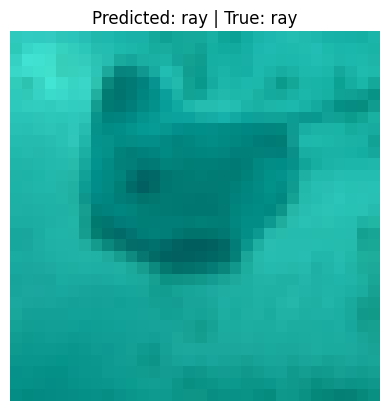

In [74]:
test_img, test_target = test_dataset[323]

model.eval()
with torch.no_grad():
    test_img = test_img.unsqueeze(0).to(device)
    test_pred = model(test_img)
    test_pred = F.softmax(test_pred, dim=1)

    test_pred = test_pred.cpu().numpy().squeeze()
    test_pred_label = np.argmax(test_pred)

    print(f"Predicted Label: {true_labels[test_pred_label]}")
    print(f"True Label: {true_labels[test_target]}")

    test_img = reverse_transform(test_img.squeeze(), train=False)
    plt.imshow(test_img)
    plt.title(
        f"Predicted: {true_labels[test_pred_label]} | True: {true_labels[test_target]}"
    )
    plt.axis("off")

    plt.show()


In [71]:
wandb.finish()

test_loss,▁
test_top1_acc,▁
test_top5_acc,▁
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁
val_loss,█▆▅▃▃▂▂▁▁▁▁▁▂▂▂
val_top1_acc,▁▂▃▄▅▆▆▇▇▇▇████
val_top5_acc,▁▃▄▅▆▆▇▇▇██████
test_loss,3.1419
test_top1_acc,0.305
test_top5_acc,0.6118
train_loss,1.53935


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>